STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# Convolutional Variational Autoencoder for MNIST

In [2]:
!pip install watermark
!pip install torchvision

%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.18.1

torch: 2.1.2


## Imports

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [4]:
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [1]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM-1}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50

# Architectures
NUM_CLASSES = 10

NameError: name 'torch' is not defined

In [6]:
# set_deterministic()
set_all_seeds(RANDOM_SEED)

## Dataset

In [7]:
##########################
### Dataset
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    validation_fraction=0.)
    

In [28]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    # Each batch of images has 256 individual images. Each image is a single-channel (grayscale) image with a dimension of 28x28 pixels.
    print('Image batch dimensions:', images.size())
    # This shows there are 256 labels corresponding to the 256 images in the batch. Each label is a single number representing the digit in the corresponding image.
    print('Image label dimensions:', labels.size())
    # These are the first 10 labels in the batch. They represent the digit each image is meant to be classified as. For example, the first image in the batch is a '1', the second is a '2', and so on.
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([5, 7, 6, 3, 4, 6, 3, 6, 6, 2])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


## Model

In [9]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28] # [256, 1, unknown, unknown] --> [256, 1, 28, 28]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            # The input tensor's shape was [batch_size=256, channels=1, H=28, W=28] 
            # The output tensor's shape will be [batch_size=256, channels=64, H=28, W=28]
            # The channel numbers of each is changed as: 1 --> 32 --> 64 --> 64.
            # Meanwhile, the image is down-sampled in this process. 
            
            # First Argument - Input Channels (1): The value 1 indicates that this layer expects a single-channel input. In the context of images, this typically means grayscale images (since RGB images would have 3 channels).
            # Second Argument - Output Channels (32): 32 means that this layer will create 32 different feature maps (channels). 
            # The stride controls how the filter convolves around the input volume. A stride of (1, 1) means the filter moves 1 unit at a time horizontally and vertically. 
            # This parameter defines the size of the filter/kernel applied to the input.
            # (3, 3) means each filter will have a height and width of 3 units. A 3x3 kernel is standard in CNNs and is effective for capturing spatial relationships in data.
            # A padding of 1 adds a one-pixel border around the input. This is often done to allow the filter to operate on the border elements of the input image, ensuring that the spatial dimensions are either preserved or controlled post-convolution.
            # Since the stride is (1, 1) and padding is 1, the spatial dimensions (height and width) of the output feature maps are the same as those of the input. Therefore, no downsampling occurs in this layer.
            # In summary, nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1) defines a convolutional layer that takes a single-channel input and applies 32 different 3x3 filters to it, moving one unit at a time and using padding to manage the spatial dimensions. 
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),

            # The key here is the stride of (2, 2). This means the filter moves 2 units at a time both horizontally and vertically. As a result, the height and width of the output feature maps are each halved compared to the input feature maps. This is where downsampling occurs.
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1), # The layer keeps the depth of the feature maps the same (64 input channels and 64 output channels). This is useful for extracting features without altering the depth of the feature maps.
                
                # `nn.Flatten()` in PyTorch is used to convert a multi-dimensional tensor into a 1D tensor (vector). 
                # For a 3D tensor [channels=64, H=28, W=28], it'll transform it into a 1D tensor with 50176 dimensions.
                # For a 4D tensor [batch_size=256, channels=64, H=28, W=28], it'll transform it into a 2D tensor [256, 50176].
            
                # The flattening is done by laying out the elements of the tensor in a single line, row by row, channel by channel.
                      
                nn.Flatten(), 
        )    
        
        # Either is is a linear layer configured to transform input vectors from a 3136-dimensional space to a 2-dimensional space
        self.z_mean = torch.nn.Linear(3136, 2)
        self.z_log_var = torch.nn.Linear(3136, 2)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136), # It takes a vector from the latent space (of size 2) and maps it to a larger space (of size 3136).
            
                Reshape(-1, 64, 7, 7), # The output is reshaped to have 64 channels, each with a spatial dimension of 7x7. This step prepares the data for subsequent transposed convolutional layers.
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1), # The first ConvTranspose2d layer maintains 64 channels, with the spatial dimensions remaining unchanged due to stride=(1, 1) and padding=1.
                nn.LeakyReLU(0.01),
            
            # The channel dimensions are gradually reduced from 64 to 32
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),             
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0), # The channel dimensions are reduced from 64 to 32      
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), # # The channel dimensions are reduced from 32 to 1     
                Trim(), 
                nn.Sigmoid() #The sigmoid function is an element-wise operation. It squashes every value of the tensor into a [0, 1] range.
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device()) # The size of eps is determined by z_mu.size(0) and z_mu.size(1), which ensure that eps has the same batch size and latent dimension size as z_mu.
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        encoded = self.encoding_fn(x)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [10]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [11]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/050 | Batch 0000/0234 | Loss: 183.5786
Epoch: 001/050 | Batch 0050/0234 | Loss: 56.7602
Epoch: 001/050 | Batch 0100/0234 | Loss: 52.0230
Epoch: 001/050 | Batch 0150/0234 | Loss: 52.6459
Epoch: 001/050 | Batch 0200/0234 | Loss: 48.5917
Time elapsed: 0.25 min
Epoch: 002/050 | Batch 0000/0234 | Loss: 47.9989
Epoch: 002/050 | Batch 0050/0234 | Loss: 46.9261
Epoch: 002/050 | Batch 0100/0234 | Loss: 45.2712
Epoch: 002/050 | Batch 0150/0234 | Loss: 43.0786
Epoch: 002/050 | Batch 0200/0234 | Loss: 44.5225
Time elapsed: 0.50 min
Epoch: 003/050 | Batch 0000/0234 | Loss: 43.5478
Epoch: 003/050 | Batch 0050/0234 | Loss: 41.4546
Epoch: 003/050 | Batch 0100/0234 | Loss: 43.2967
Epoch: 003/050 | Batch 0150/0234 | Loss: 42.0593
Epoch: 003/050 | Batch 0200/0234 | Loss: 43.7774
Time elapsed: 0.74 min
Epoch: 004/050 | Batch 0000/0234 | Loss: 43.1064
Epoch: 004/050 | Batch 0050/0234 | Loss: 41.1274
Epoch: 004/050 | Batch 0100/0234 | Loss: 42.0439
Epoch: 004/050 | Batch 0150/0234 | Loss: 42.0194

## Evaluation

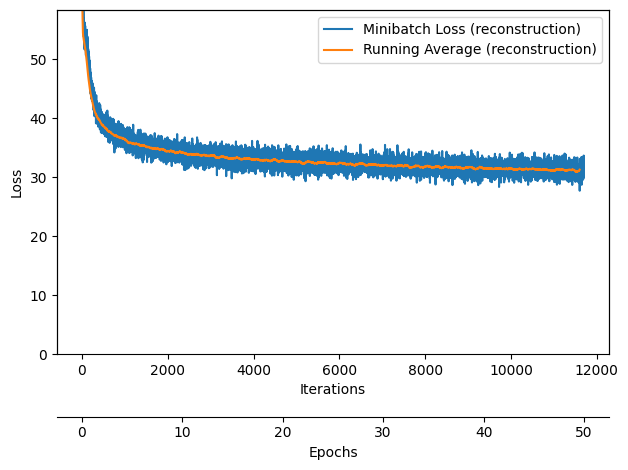

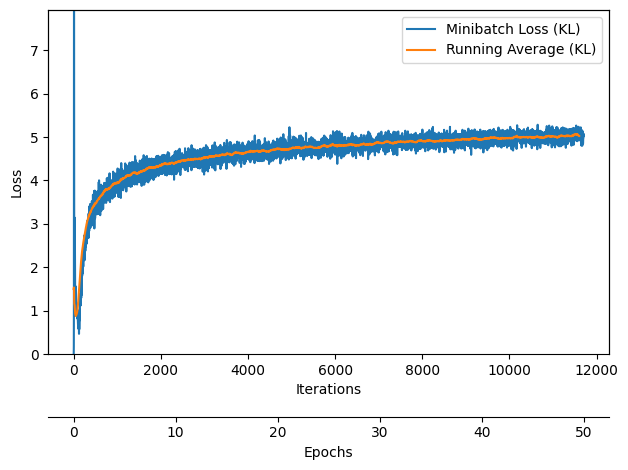

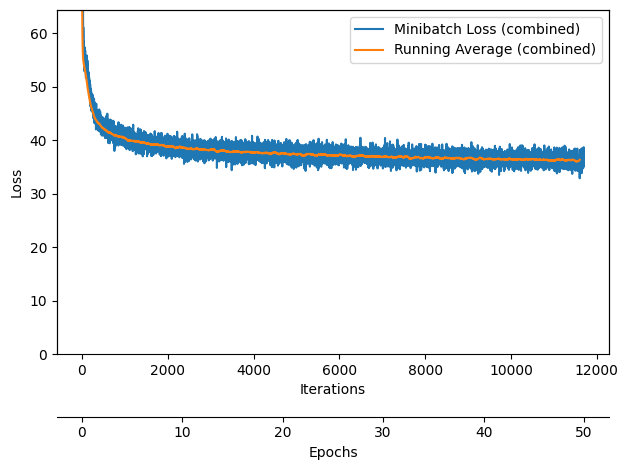

In [14]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

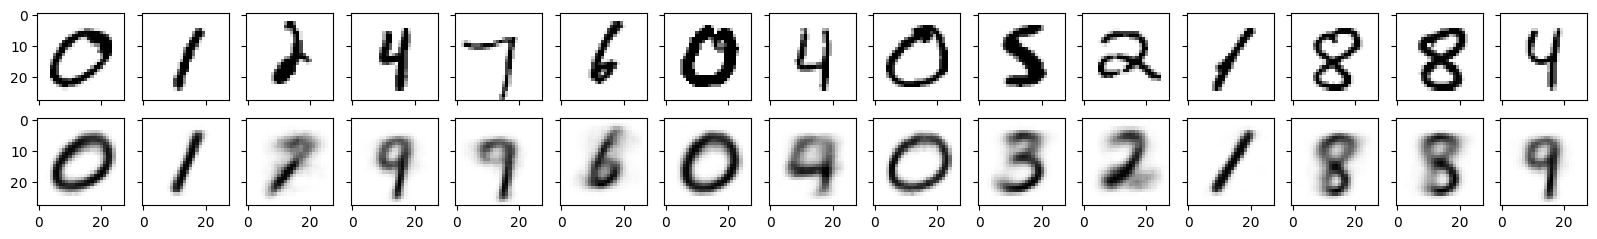

In [22]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE, modeltype='VAE')           

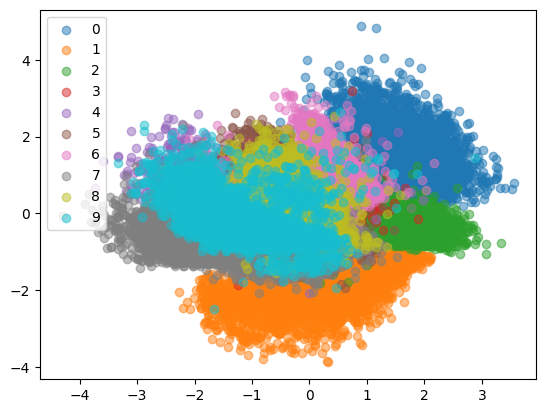

In [25]:
plot_latent_space_with_labels(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn, 
    device=DEVICE)

plt.legend()
plt.show()

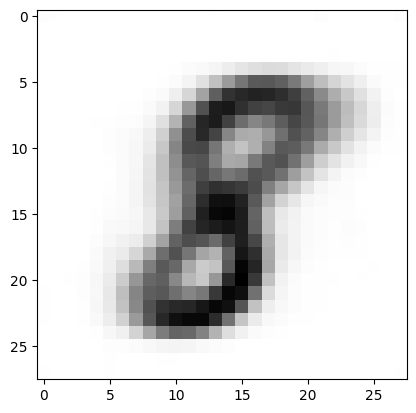

In [26]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-0.0, 0.03]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

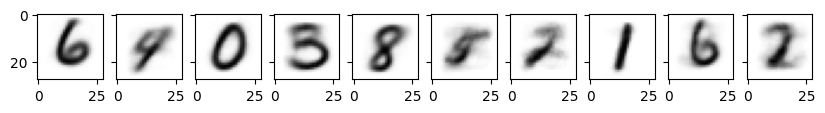

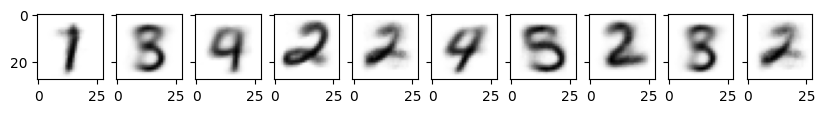

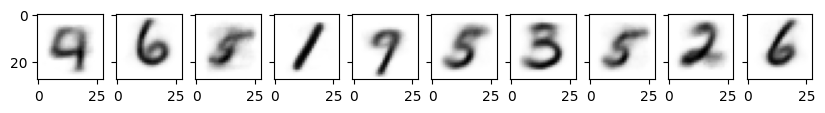

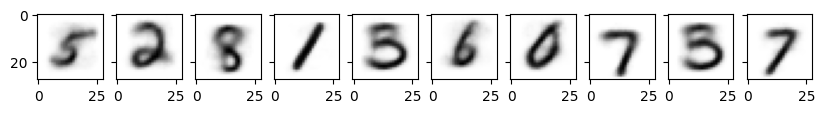

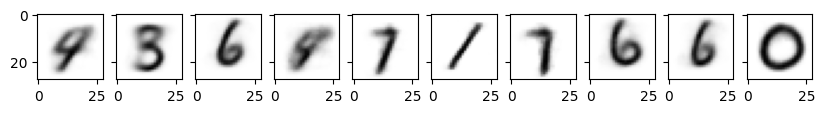

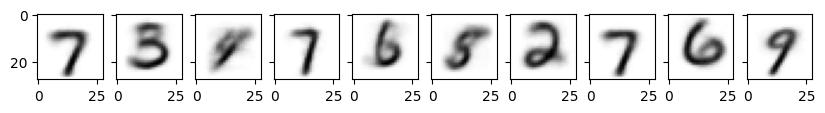

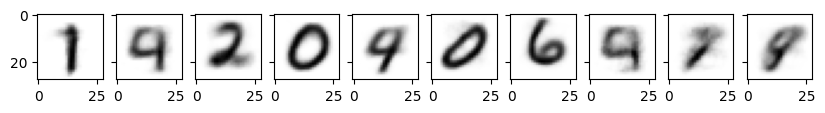

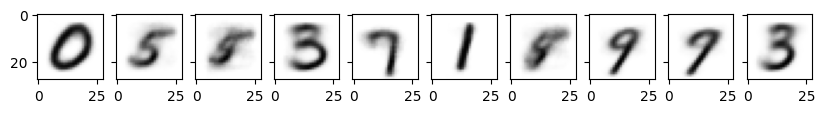

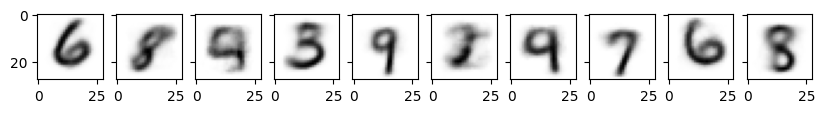

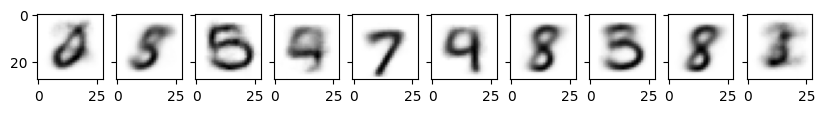

In [27]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=2)
    plt.show()